In [1]:
import os
from pathlib import Path

# Root directory
data_dir = Path("data")

# Image path
image_path = Path(data_dir / "images")

# Create train directory
train_dir = os.path.join(data_dir, "train")
if not os.path.isdir(train_dir):
    os.mkdir(train_dir)

# Create pedestrian in train directory
pedestrian_train_dir = os.path.join(train_dir, "pedestrian")
if not os.path.isdir(pedestrian_train_dir):
    os.mkdir(pedestrian_train_dir)

# Create no pedestrian in train directory
no_pedestrian_train_dir = os.path.join(train_dir, "no-pedestrian")
if not os.path.isdir(no_pedestrian_train_dir):
    os.mkdir(no_pedestrian_train_dir)

# Create test directory
test_dir = os.path.join(data_dir, "test")
if not os.path.isdir(test_dir):
    os.mkdir(test_dir)

# Create pedestrian in test directory
pedestrian_test_dir = os.path.join(test_dir, "pedestrian")
if not os.path.isdir(pedestrian_test_dir):
    os.mkdir(pedestrian_test_dir)

# Create no pedestrian in test directory
no_pedestrian_test_dir = os.path.join(test_dir, "no-pedestrian")
if not os.path.isdir(no_pedestrian_test_dir):
    os.mkdir(no_pedestrian_test_dir)

In [2]:
import random

# Get a list of all images
images = list(Path(image_path).glob("*.jpg"))

# Split images, 70% for training, 30% for testing
split = 0.7

# Get random 70% of images for training
train_split = random.sample(images, k=int(len(images) * split))

# Get remaining 30% of images for testing
test_split = [i for i in images if i not in train_split]

len(train_split), len(test_split)

(0, 0)

In [3]:
# Find 'pedestrian' labeled images in train_split
pedestrian_train_images = [i for i in train_split if i.stem.startswith('pedestrian')]
print(len(pedestrian_train_images))

# Find 'no-pedestrian' labeled images in train_split
no_pedestrian_train_images = [i for i in train_split if i.stem.startswith('no-pedestrian')]
print(len(no_pedestrian_train_images))

# Find 'pedestrian' labeled images in test_split
pedestrian_test_images = [i for i in test_split if i.stem.startswith('pedestrian')]
print(len(pedestrian_test_images))

# Find 'no-pedestrian' labeled images in test_split
no_pedestrian_test_images = [i for i in test_split if i .stem.startswith('no-pedestrian')]
print(len(no_pedestrian_test_images))

0
0
0
0


In [4]:
import shutil

# Move 'pedestrian' train images to 'train/pedestrian'
if len(pedestrian_train_images) != len(os.listdir(pedestrian_train_dir)):
    for i in pedestrian_train_images:
        shutil.move(i, pedestrian_train_dir)

# Move 'no-pedestrian' train images to 'train/no-pedestrian'
if len(no_pedestrian_train_images) != len(os.listdir(no_pedestrian_train_dir)):
    for i in no_pedestrian_train_images:
        shutil.move(i, no_pedestrian_train_dir)

# Move 'pedestrian' test images to 'test/pedestrian'
if len(pedestrian_test_images) != len(os.listdir(pedestrian_test_dir)):
    for i in pedestrian_test_images:
        shutil.move(i, pedestrian_test_dir)

# Move 'no-pedestrian' test images to 'test/no-pedestrian'
if len(no_pedestrian_test_images) != len(os.listdir(no_pedestrian_test_dir)):
    for i in no_pedestrian_test_images:
        shutil.move(i, no_pedestrian_test_dir)

In [5]:
from torchvision import datasets, transforms, models
from torch import nn

# Get weights of ResNet18 model
weights = models.ResNet18_Weights.DEFAULT

# View ResNet18 transforms from weights to copy
resnet18_transforms = weights.transforms()
print(f"RestNet18 transforms\n: {resnet18_transforms}")

# Create transforms
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

RestNet18 transforms
: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [6]:
# Create train dataset
train_data = datasets.ImageFolder(train_dir, transform=manual_transforms)

# Create test dataset
test_data = datasets.ImageFolder(test_dir, transform=manual_transforms)

# Get class names
class_names = train_data.classes

# Print info
print(train_data)
print(test_data)
print(class_names)

Dataset ImageFolder
    Number of datapoints: 140
    Root location: data\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 60
    Root location: data\test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
['no-pedestrian', 'pedestrian']


In [7]:
from torch.utils.data import DataLoader

# Set batch size
BATCH_SIZE = 8

# Create train dataloader
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)

# Print length of both dataloaders
print(len(train_dataloader))
print(len(test_dataloader))

18
8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class: no-pedestrian


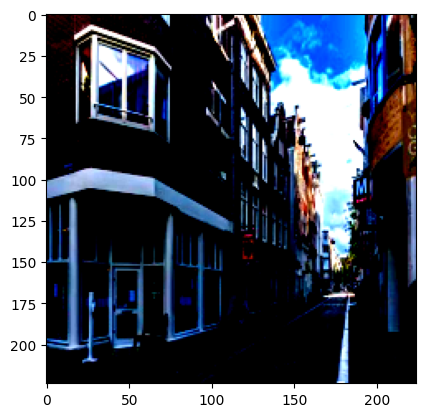

In [8]:
import matplotlib.pyplot as plt

# Iterate through train_dataloader and plot first image and label
images, labels = next(iter(train_dataloader))

# Print the first image and label of train dataloader
img = images[0].permute(1, 2, 0)
label = class_names[labels[0]]
print(f"Class: {label}")
plt.imshow(img)

In [9]:
import torch
from torchinfo import summary

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model
model = models.resnet18(weights=weights)

# Print summary of model before model parameter freeze
print(summary(model=model,
              input_size=(BATCH_SIZE, 3, 224, 224),
              col_names=["input_size", "output_size", "num_params", "trainable"],
              col_width=20,
              row_settings=["var_names"]))

# Get number of parameters going into last layer, need this to change final layer
in_features = model.fc.in_features

# Get length of class_names
output_shape = len(class_names)

# Freeze model params
for params in model.parameters():
    params.requires_grad = False

# Create new classifier
model.fc = nn.Sequential(
    nn.Linear(in_features, output_shape)
).to(device)

# Make classifier trainable
for params in model.fc.parameters():
    params.requires_grad = True

# Put model to device
model = model.to(device)

# Print summary of model after model parameter freeze
print(summary(model=model,
              input_size=(BATCH_SIZE, 3, 224, 224),
              col_names=["input_size", "output_size", "num_params", "trainable"],
              col_width=20,
              row_settings=["var_names"]))


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [8, 3, 224, 224]     [8, 1000]            --                   True
├─Conv2d (conv1)                         [8, 3, 224, 224]     [8, 64, 112, 112]    9,408                True
├─BatchNorm2d (bn1)                      [8, 64, 112, 112]    [8, 64, 112, 112]    128                  True
├─ReLU (relu)                            [8, 64, 112, 112]    [8, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [8, 64, 112, 112]    [8, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [8, 64, 56, 56]      [8, 64, 56, 56]      --                   True
│    └─BasicBlock (0)                    [8, 64, 56, 56]      [8, 64, 56, 56]      --                   True
│    │    └─Conv2d (conv1)               [8, 64, 56, 56]      [8, 64, 56, 56]      36,864               True
│    │    └─BatchN

In [10]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Get batch of images and labels
image_batch, label_batch = next(iter(train_dataloader))

# Get first image and label from batch and print shape of image
img, label = image_batch[0].unsqueeze(0), label_batch[0]
print(f"Image shape: {img.shape}")

# Put model into eval() mode and put image through model
model.eval()
with torch.inference_mode():
    pred = model(img.to(device))

# Print results
print(f"Output logits: {pred}")
print(f"Output prediction probabilities: {torch.softmax(pred, dim=1)}")
print(f"Output prediction label: {torch.argmax(torch.softmax(pred, dim=1), dim=1)}")
print(f"True label: {label}")

Image shape: torch.Size([1, 3, 224, 224])
Output logits: tensor([[-0.1500, -0.8054]], device='cuda:0')
Output prediction probabilities: tensor([[0.6582, 0.3418]], device='cuda:0')
Output prediction label: tensor([0], device='cuda:0')
True label: 1


In [12]:
# Train the model
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module, 
          optimizer: torch.optim.Optimizer, 
          epochs: int=10):
    
    # Create a results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    # Loop through each batch 
    for epoch in range(epochs):

        # Put model into train mode
        model.train()

        # Setup train loss and accuracy values
        train_loss, train_acc = 0, 0

        # Loop through train dataloader batches
        for batch, (images, labels) in enumerate(train_dataloader):

            # Send data to target device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = loss_fn(outputs, labels)

            # Accumulate loss
            train_loss = train_loss + loss.item()

            # Optimizer zero grad
            optimizer.zero_grad()

            # Loss backward
            loss.backward()

            # Optimizer step
            optimizer.step()

            # Get the models predicted labels
            predicted_labels = torch.argmax(torch.softmax(outputs, dim=1), dim=1)

            # Calculate train accuracy based on how many labels the model predicted correctly
            train_acc = train_acc + (predicted_labels == labels).sum().item() / len(outputs)
        
            # Put model in evalulation mode
            model.eval()

            # Setup test loss and accuracy values
            test_loss, test_acc = 0, 0

        # Turn on inference context manager
        with torch.inference_mode():
            
            # Loop through test dataloader batches
            for batch, (images, labels) in enumerate(test_dataloader):
                
                # Send data to target device
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate loss
                loss = loss_fn(outputs, labels)

                # Accumulate loss
                test_loss =  test_loss + loss.item()

                # Get the models predicted labels
                predicted_labels = torch.argmax(torch.softmax(outputs, dim=1), dim=1)

                #Calculate test accuracy based on how many labels the model predicted correctly
                test_acc = test_acc + (predicted_labels == labels).sum().item() / len(outputs)

        # Adjust the metrcis to get the average train loss, train accuracy, test loss, and test accuracy per batch
        train_loss = train_loss / len(train_dataloader)
        train_acc = (train_acc / len(train_dataloader)) * 100
        test_loss = test_loss / len(test_dataloader)
        test_acc = (test_acc / len(test_dataloader)) * 100

        # Print out what is happening
        print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.2f}% | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.2f}%")

        # Append values to results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    # Return the results at the end of the epochs
    return results

In [13]:
# Train and test the model
train(model, train_dataloader, test_dataloader, loss_fn, optimizer, 10)

Epoch: 1 | Train loss: 0.6479 | Train accuracy: 63.19% | Test loss: 0.5334 | Test accuracy: 79.69%
Epoch: 2 | Train loss: 0.3912 | Train accuracy: 90.28% | Test loss: 0.3989 | Test accuracy: 84.38%
Epoch: 3 | Train loss: 0.2916 | Train accuracy: 90.97% | Test loss: 0.3303 | Test accuracy: 87.50%
Epoch: 4 | Train loss: 0.2380 | Train accuracy: 95.14% | Test loss: 0.2900 | Test accuracy: 90.62%
Epoch: 5 | Train loss: 0.1977 | Train accuracy: 95.14% | Test loss: 0.2497 | Test accuracy: 93.75%
Epoch: 6 | Train loss: 0.1730 | Train accuracy: 95.14% | Test loss: 0.2507 | Test accuracy: 93.75%
Epoch: 7 | Train loss: 0.1550 | Train accuracy: 96.53% | Test loss: 0.2230 | Test accuracy: 95.31%
Epoch: 8 | Train loss: 0.1444 | Train accuracy: 97.22% | Test loss: 0.2200 | Test accuracy: 93.75%
Epoch: 9 | Train loss: 0.1274 | Train accuracy: 98.61% | Test loss: 0.2087 | Test accuracy: 95.31%
Epoch: 10 | Train loss: 0.1184 | Train accuracy: 100.00% | Test loss: 0.2347 | Test accuracy: 93.75%


{'train_loss': [0.6479025483131409,
  0.3912384725279278,
  0.2916017501718468,
  0.23798795458343294,
  0.19765902103649247,
  0.17299185403519207,
  0.1550360582768917,
  0.14438476579056847,
  0.1273825161365999,
  0.11835792743497425],
 'train_acc': [63.19444444444444,
  90.27777777777779,
  90.97222222222221,
  95.13888888888889,
  95.13888888888889,
  95.13888888888889,
  96.52777777777779,
  97.22222222222221,
  98.61111111111111,
  100.0],
 'test_loss': [0.5334064960479736,
  0.3989231064915657,
  0.3303331919014454,
  0.29003856889903545,
  0.24971861578524113,
  0.2506649186834693,
  0.22296039294451475,
  0.22002852708101273,
  0.20873541943728924,
  0.23470675386488438],
 'test_acc': [79.6875,
  84.375,
  87.5,
  90.625,
  93.75,
  93.75,
  95.3125,
  93.75,
  95.3125,
  93.75]}

In [14]:
# Save the model
torch.save(obj=model.state_dict(),
           f="resnet18-real-time-pedestrian-detection-model.pth")

In [19]:
from PIL import Image

# Get an image
image = Image.open('data/train/pedestrian/pedestrian (11).jpg')

In [20]:
# Predict function
def predict(image):
    
    model.to(device)

    # Transform the image
    transformed_image = manual_transforms(image).unsqueeze(0).to(device)

    # Put model in evaluation mode
    model.eval()

    # Turn on inference context manager
    with torch.inference_mode():

        # Send image through model and get prediction probabilites
        pred_probs = torch.softmax(model(transformed_image), dim=1)
    
    # Get labels and the corresponding prediction probaility
    pred_label_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Return prediction labels and there predicted probabilities
    return pred_label_and_probs

In [21]:
# Send image through predict function
predict(image=image)

{'no-pedestrian': 0.03861144557595253, 'pedestrian': 0.9613885283470154}

In [ ]:
import cv2
import torchvision

# Initializing the HOG person detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Get frames
cap = cv2.VideoCapture('video.mp4')

if (cap.isOpened() == False):
   print("Error opening video stream or file.")

while (cap.isOpened()):
  
  # Read the frame
  ret, frame = cap.read()
  if ret == True:
    
    # Detect all regions where a pedestrian is detected
    (rects, weights) = hog.detectMultiScale(frame,
                                          winStride=(4, 4),
                                          padding=(4, 4),
                                          scale=1.05)
    
    # Draw the regions
    for (x, y, w, h) in rects:
       cv2.rectangle(frame, (x, y),
                    (x + w, y + h),
                    (0, 255, 0), 2)
    
    # Convert frame logs to tensor
    np_to_tensor_frame_logs = torchvision.transforms.ToTensor()(frame)
    
    # Convert tensor logs to PIL for prediction
    tensor_to_pil_frame_logs = torchvision.transforms.ToPILImage()(np_to_tensor_frame_logs)
    
    # Send PIL frame logs to predict function
    prediction = predict(tensor_to_pil_frame_logs)

    # Get each labels accuracy probabilities
    no_pedestrian_accuracy = (list(prediction.items())[0][1]) * 100
    pedestrian_accuracy = (list(prediction.items())[1][1]) * 100
    
    # If no pedestrian detected, display accuracy of statement, set text color to red
    if no_pedestrian_accuracy > pedestrian_accuracy:
       cv2.putText(frame, f"No pedestrian detected with {no_pedestrian_accuracy:.2f}% confidence",
                    org=(0, 50), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.5,
                    color=(51, 51, 255), thickness=2)
    # If pedestrian detected, display accuracy of statement, set text color to green
    else:
       cv2.putText(frame, f"Pedestrian detected with {pedestrian_accuracy:.2f}% confidence",
                    org=(0, 50), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.5,
                    color=(0, 255, 0), thickness=2)
    
   # Display the frame
    cv2.imshow('Frame', frame)

    # Break out of while loop if 'esc' button is pushed
    key = cv2.waitKey(1)
    if key == 27:
        break

# Kill the camera
cap.release()
cv2.destroyAllWindows()